## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from prettytable import PrettyTable
%matplotlib widget

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [44]:
def scale(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

def descale(X, X_old):
    return (X_old.max(axis=0) - X_old.min(axis=0)) * X + X_old.min(axis=0)

# plot train and validation loss
%matplotlib widget

def plot_loss(loss, val_loss, epoch=(-1, -1)):
    fig = plt.figure()

    if epoch[0] == -1:
        start_idx = 0
    else:
        start_idx = epoch[0]

    if epoch[1] == -1:
        end_idx = len(loss)
    else:
        end_idx = epoch[1]
    loss = loss[start_idx: end_idx]
    val_loss = val_loss[start_idx: end_idx]
    plt.plot(np.arange(start_idx, end_idx), loss, label='train')
    plt.plot(np.arange(start_idx, end_idx), val_loss, label='validation')
    plt.title('Model Accuracy')
    plt.ylabel(criterion_name)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    plt.close()




In [45]:
# Load the data
df = pd.read_pickle('./data/transfer-functions.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-28.17844516431674, -29.995330137199815, -26...."
1,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-21.519000119295377, -20.82520269965962, -23...."
2,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.78282633317538, -23.116844835167647, -23...."
3,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-19.483532441089714, -25.181283644031062, -34..."
4,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-24.21908363783242, -27.164085696072963, -24...."


In [46]:
# quantize the output features
# factorized, uniques = pd.factorize(df['phi'])
# print(uniques)
# df['phi'] = factorized

# factorized, uniques = pd.factorize(df['g_oo'])
# print(uniques)
# df['g_oo'] = factorized


phi_encoder = preprocessing.LabelEncoder()
df['phi_label'] = phi_encoder.fit_transform(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
df['g_oo_label'] = gain_encoder.fit_transform(df['g_oo'])
print(gain_encoder.classes_)


print(df.dtypes)



[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.0001     0.00062105 0.00114211 0.00166316 0.00218421 0.00270526
 0.00322632 0.00374737 0.00426842 0.00478947 0.00531053 0.00583158
 0.00635263 0.00687368 0.00739474 0.00791579 0.00843684 0.00895789
 0.00947895 0.01      ]
phi           float64
g_oo          float64
x              object
y              object
phi_label       int64
g_oo_label      int64
dtype: object


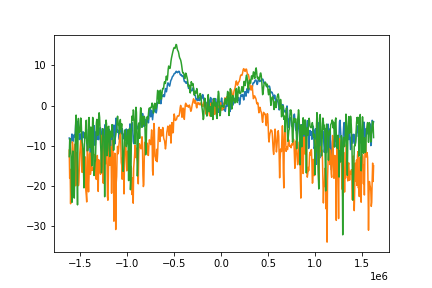

In [47]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [23]:
# Extract the target variables
param_a_label = df.pop('phi_label')
param_b_label = df.pop('g_oo_label')

param_a = df.pop('phi')
param_b = df.pop('g_oo')


# All x should be equal
x = df.iloc[0].x.astype(np.float32)
df.drop(columns='x', inplace=True)

In [24]:
# target is the target vector
target = np.array((param_a_label, param_b_label), dtype=np.uint8).T

target_original = np.array((param_a, param_b)).T

# scaled_target = scale(target)
# target_scaler = preprocessing.StandardScaler().fit(target)
# print(target_scaler.mean_)
# print(target_scaler.scale_)
# scaled_target = target_scaler.transform(target)
target = torch.tensor(target, dtype=torch.uint8)
print(target[5:15])
# scaler_target = preprocessing.MinMaxScaler()
# scaled_target = torch.tensor(scaled_target)
# print(scaled_target[5:15])

tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


In [25]:
# Only the input points have been left
df.head()

,y
0,"[-28.17844516431674, -29.995330137199815, -26...."
1,"[-21.519000119295377, -20.82520269965962, -23...."
2,"[-22.78282633317538, -23.116844835167647, -23...."
3,"[-19.483532441089714, -25.181283644031062, -34..."
4,"[-24.21908363783242, -27.164085696072963, -24...."


In [26]:
values = np.zeros((len(df), len(df.iloc[0,0])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row.values[0]
    index += 1
print(values.shape)
print(type(values))

(8200, 662)
<class 'numpy.ndarray'>


In [27]:
# Convert data to torch tensor
data_scaler = preprocessing.StandardScaler().fit(values)
# scaled_values = scale(values)
scaled_values = data_scaler.transform(values)
# scaled_values = values
# print(data_scaler.mean_)
# print(data_scaler.scale_)
data = torch.tensor(scaled_values)
# data = torch.tensor(values, dtype=torch.float32)
print(data)

tensor([[-1.8263, -1.8163, -1.4602,  ..., -0.8931, -1.3857, -1.0064],
        [-1.2087, -0.9554, -1.1558,  ..., -1.2633, -1.3160, -1.4712],
        [-1.3259, -1.1706, -1.2252,  ..., -0.6888, -0.7939, -0.9047],
        ...,
        [ 0.0267,  0.7295,  0.7233,  ...,  0.7677,  0.7085, -0.0479],
        [ 0.2251,  0.7152,  0.8274,  ..., -0.0357, -0.0558, -0.1208],
        [ 0.0702,  0.5890,  0.5390,  ..., -0.4001, -0.2153,  0.1427]])


In [28]:
# Split in train and test
X_train, X_test, y_train, y_test, y_train_original, y_test_original = train_test_split(data, target, target_original, test_size=0.2, random_state=2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([6560, 662])
torch.Size([1640, 662])
torch.Size([6560, 2])
torch.Size([1640, 2])


In [29]:
# Define the network architecture2

class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, name='classifer', activation_func=F.gelu,
                 hidden_1=140, hidden_2=110, hidden_3=0,
                 kernel_size=10, stride=10, trim_edges=120, save_best=True):
        super(Net, self).__init__()
        self.activate = activation_func
        self.name = name
        self.save_best = save_best
        # A layer that trims out the edges
        self.center = nn.ConstantPad1d(-trim_edges, 0)
        n_inputs -= 2 * trim_edges
        # An avgpooling layer to smoothen the curve
        padding = 0
        n_pool_out = (n_inputs + 2 * padding - kernel_size)//stride +1
        self.pool1 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)

        # linear layer (n_pool_out -> hidden_1)
        self.fc1 = nn.Linear(n_pool_out, hidden_1)

        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)

        # linear layer (n_hidden -> n_outputs)
        if hidden_3 > 0:
            self.fc3 = nn.Linear(hidden_2, hidden_3)
            self.fc4 = nn.Linear(hidden_3, n_outputs)
        else:
            self.fc3 = nn.Linear(hidden_2, n_outputs)
            self.fc4 = None

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # remove some points from the edges
        x = self.center(x)

        # This performs the average pooling layer
        x = self.pool1(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        if self.fc4:
            x = self.dropout(self.activate(self.fc3(x)))
            # add outputlayer
            x = self.fc4(x)
        else:
            # add output layer
            x = self.fc3(x)

        # Output layer with softmax activation
        x = F.log_softmax(x, dim=1)

        return x


    def get_accuracy(self, log_probs, labels):
        ps = torch.exp(log_probs)
        top_p, top_class = ps.topk(1, dim=1)
        # print(top_class.shape)
        # print(top_class.view(-1)[:5])
        # print(labels.shape)
        # print(labels.view(-1)[:5])
        n_correct = top_class == labels.view(*top_class.shape)
        # n_correct = torch.eq(top_class.view(-1,), labels.view(-1))
        # print(n_correct.sum().item())
        # n_correct = torch.sum((torch.abs(pred_arr-original_arr) < torch.abs(pct * original_arr)))
        acc = (n_correct.sum().item() * 100.0 / len(labels))
        return acc


    def save(self, name='model.pt'):
        torch.save(self.state_dict(), name)


    def train_net(self, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs=100):
        l_train_loss=[]
        l_train_accuracy=[]
        l_test_loss=[]
        l_test_accuracy=[]
        min_test_loss = np.Inf
        for epoch in range(num_epochs):
            # put the model in training mode
            self.train()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output_train = self(X_train)

            l_train_accuracy.append(self.get_accuracy(output_train, y_train))

            #calculate the loss
            train_loss = criterion(output_train, y_train)
            l_train_loss.append(train_loss.item())

            #backward pass: compute gradient of the loss with respect to model parameters
            train_loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            with torch.no_grad():
                output_test = self(X_test)
                test_loss = criterion(output_test, y_test)
                l_test_loss.append(test_loss.item())
                l_test_accuracy.append(self.get_accuracy(output_test, y_test))

            if l_test_loss[-1] < min_test_loss:
                print(f"Epoch {epoch+1}/{num_epochs}: Test loss decreased ({min_test_loss:.6f} --> {l_test_loss[-1]:.6f})")
                if self.save_best:
                    self.save(f'models/{self.name}.pt')
                min_test_loss = l_test_loss[-1]

            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {l_train_loss[-1]:.4f}, Test Loss: {l_test_loss[-1]:.4f}")

        return l_train_loss, l_train_accuracy, l_test_loss, l_test_accuracy


In [31]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 0]))
model1 = Net(n_inputs, n_outputs, name='classifier1', activation_func=F.gelu,
                hidden_1=420, hidden_2=70, hidden_3=0,
                kernel_size=4, stride=4, trim_edges=110, save_best=True)
print(model1)

# specify loss function (regression)
criterion = nn.NLLLoss(); criterion_name = 'NLL'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-110, -110), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=110, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=70, bias=True)
  (fc3): Linear(in_features=70, out_features=41, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# train the network
train_loss1, train_accuracy1, test_loss1, test_accuracy1 = model1.train_net(
    optimizer1, criterion, X_train, y_train[:, 0].view(-1,), X_test, y_test[:, 0].view(-1,), 500)

In [ ]:
plot_loss(train_loss1, test_loss1, epoch=(50,-1))
plot_loss(train_accuracy1, test_accuracy1, epoch=(50, -1))
print('Max accuracy: ', np.max(test_accuracy1))

In [32]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo

n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 1]))

model2 = Net(n_inputs, n_outputs, name='classifier2', activation_func=F.gelu,
                hidden_1=420, hidden_2=350, hidden_3=0,
                kernel_size=4, stride=4, trim_edges=120, save_best=True)
print(model2)

# specify loss function (regression)
criterion = nn.NLLLoss(); criterion_name = 'NLLLoss'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=105, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# train the network

train_loss2, train_accuracy2, test_loss2, test_accuracy2 = model2.train_net(
    optimizer2, criterion, X_train, y_train[:, 1].view(-1,), X_test, y_test[:, 1].view(-1,), 500)

In [ ]:
plot_loss(train_loss2, test_loss2, epoch=(50, -1))
plot_loss(train_accuracy2, test_accuracy2, epoch=(50, -1))
print('Max accuracy: ', np.max(test_accuracy2))


In [ ]:
# Hyper parameter tuning
# criterion = nn.L1Loss(); criterion_name = 'MAE'
n_inputs = data.shape[1]
n_outputs = len(np.unique(target[:, 0]))
test_results = []
num_epochs = 150
# for activ_f, activ_f_name in [(F.relu, 'relu'), (F.relu6, 'relu6'), (F.gelu, 'gelu')]:
for activ_f, activ_f_name in [(F.gelu, 'gelu')]:
    for kernel_size, stride in [(4, 4)]:
        for hidden_1 in [420]:
            for hidden_2 in [70]:
                for hidden_3 in [0]:
                    for trim_edges in [110]:
                        print(f"Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim "
                              f"= ({activ_f_name}, {kernel_size}, {stride},"
                              f"{hidden_1}, {hidden_2}, {hidden_3}, {trim_edges})")
                        model = Net(n_inputs, n_outputs, name='classifier1', activation_func=activ_f,
                                    hidden_1=hidden_1, hidden_2=hidden_2, hidden_3=hidden_3,
                                    kernel_size=kernel_size, stride=stride, trim_edges=trim_edges, save_best=False)
                        criterion = nn.NLLLoss(); criterion_name = 'NLLLoss'
                        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
                            optimizer, criterion, X_train, y_train[:, 0].view(-1), X_test, y_test[:, 0].view(-1), num_epochs)
                        test_results.append([activ_f_name, kernel_size, stride, hidden_1, hidden_2, hidden_3,
                                             trim_edges, np.min(test_loss)])
        # plot_loss(train_loss, test_loss, epoch=(10,-1))

table = PrettyTable()
table.field_names = ["activation", "kernel size", "stride",
                     "hidden_1", "hidden_2", "hidden_3", "trim_edges", "Min Loss"]
test_results.sort(key=lambda x: x[-1])
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

In [ ]:
# Hyper parameter tuning
# criterion = nn.L1Loss(); criterion_name = 'MAE'
n_inputs = data.shape[1]
n_outputs = len(np.unique(target[:, 1]))
test_results = []
num_epochs = 150
# for activ_f, activ_f_name in [(F.relu, 'relu'), (F.relu6, 'relu6'), (F.gelu, 'gelu')]:
for activ_f, activ_f_name in [(F.gelu, 'gelu')]:
    for kernel_size, stride in [(4,4)]:
        for hidden_1 in [420]:
            for hidden_2 in [350]:
                for hidden_3 in [0]:
                    for trim_edges in [120]:
                        print(f"Training net with: activation, kernel_size, stride, h_1, h_2, h_3, trim "
                              f"= ({activ_f_name}, {kernel_size}, {stride},"
                              f"{hidden_1}, {hidden_2}, {hidden_3}, {trim_edges})")
                        model = Net(n_inputs, n_outputs, name='classifier2', activation_func=activ_f,
                                    hidden_1=hidden_1, hidden_2=hidden_2, hidden_3=hidden_3,
                                    kernel_size=kernel_size, stride=stride, trim_edges=trim_edges, save_best=False)
                        criterion = nn.NLLLoss(); criterion_name = 'NLLLoss'
                        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                        train_loss, train_accuracy, test_loss, test_accuracy = model.train_net(
                            optimizer, criterion, X_train, y_train[:, 1].view(-1), X_test, y_test[:, 1].view(-1), num_epochs)
                        test_results.append([activ_f_name, kernel_size, stride, hidden_1, hidden_2, hidden_3,
                                             trim_edges, np.min(test_loss)])
        # plot_loss(train_loss, test_loss, epoch=(10,-1))


In [ ]:
table = PrettyTable()
table.field_names = ["activation", "kernel size", "stride",
                     "hidden_1", "hidden_2", "hidden_3", "trim_edges", "Min Loss"]
test_results.sort(key=lambda x: x[-1])
for row in test_results:
    table.add_row(row)
# print('kernel_size, stride, Min loss')
print(table)

In [33]:
# load model with the highest accuracy
# model1.load_state_dict(torch.load('models/model1.pt'))
# model2.load_state_dict(torch.load('models/model2.pt'))

model1.load_state_dict(torch.load('models/model1-classifier-acc50.pt'))
model2.load_state_dict(torch.load('models/model2-classifier-acc99.pt'))


<All keys matched successfully>

In [34]:
# make predictions
random_idx = np.random.choice(np.arange(len(X_test)), size=100, replace=False)
X_validate = X_test[random_idx]
y_validate = y_test[random_idx]
y_validate_new = y_test_original[random_idx]
# print(y_validate_new)
# print(y_validate)

In [35]:
with torch.no_grad():
    yhat1 = model1(X_validate)
    yhat2 = model2(X_validate)

# Extract top category
_, yhat1 = torch.exp(yhat1).topk(1, dim=1)
_, yhat2 = torch.exp(yhat2).topk(1, dim=1)
# Convert from category to value
yhat1 = phi_encoder.inverse_transform(yhat1.ravel().numpy())
yhat2 = gain_encoder.inverse_transform(yhat2.ravel().numpy())
yhat = np.array([yhat1, yhat2]).T.reshape(-1, 2)
yhat_new = yhat

# Descale the input values
X_validate_new = data_scaler.inverse_transform(X_validate.numpy())
#


+-----+-------+----------------------+----------------------+----------------------+
| idx | param |       original       |        model         |         opt          |
+-----+-------+----------------------+----------------------+----------------------+
|  90 |  phi  |         19.0         |         18.0         |   4.84068979759763   |
|  90 |  g_oo | 0.008436842105263158 | 0.008436842105263158 | 0.00461773506569214  |
|  95 |  phi  |         -9.0         |        -10.0         | -19.999999999984826  |
|  95 |  g_oo | 0.005831578947368421 | 0.005831578947368421 | 0.009999999999999998 |
|  95 |  phi  |         -9.0         |        -10.0         | -19.999999999984826  |
|  95 |  g_oo | 0.005831578947368421 | 0.005831578947368421 | 0.009999999999999998 |
+-----+-------+----------------------+----------------------+----------------------+


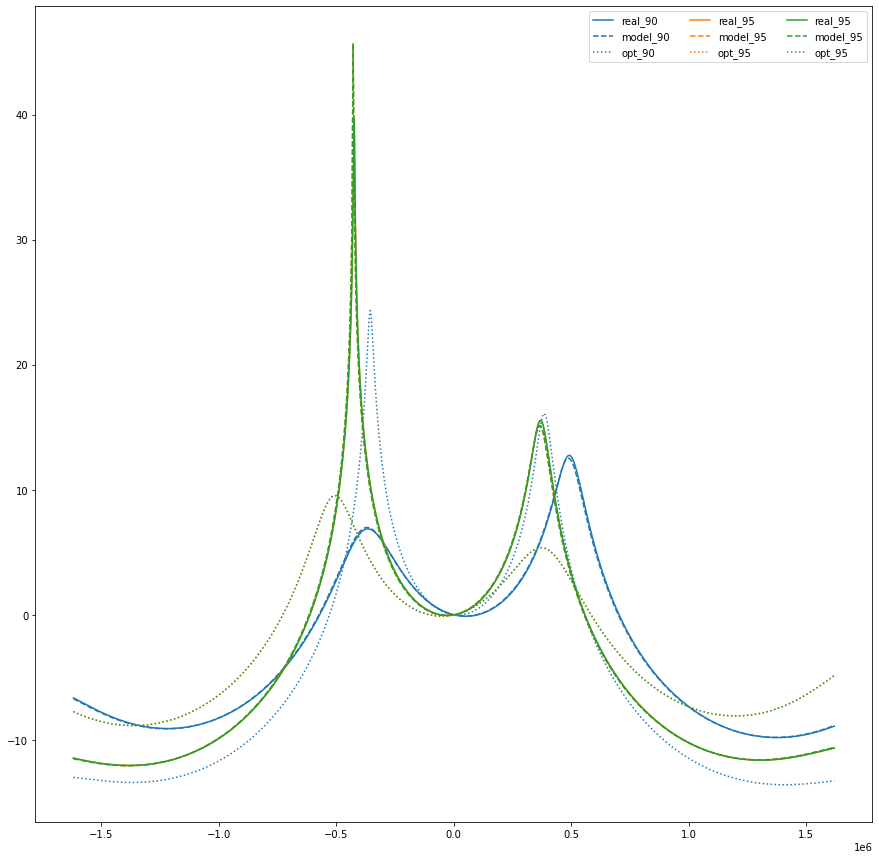

In [48]:
# plot the validation curves
%matplotlib inline

plt.figure(figsize=(15, 15))
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
x = gen_tf.frequency.astype(np.float32)

table = PrettyTable()
table.field_names = ["idx", "param", "original", "model", "opt"] #, "model+opt"]
# print(table)

for idx in np.random.choice(np.arange(0, len(X_validate_new)), size=3):
    try:
        popt, _  = curve_fit(gen_tf, x, X_validate_new[idx], bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
        # Initial guesses coming from the model
        # poptModel,_ = curve_fit(gen_tf, x, X_validate_new[idx], bounds=([-20, 1e-4], [20, 1e-2]), method='trf', p0=yhat_new[idx])
    except:
        print(f'Scipy curve fit failed for idx: {idx}')
        continue

    # print('Param, Original, Model, Optimizer')
    table.add_row([idx, 'phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0]]) #, poptModel[0]])
    table.add_row([idx, 'g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1]]) #, poptModel[1]])

    # print('phi', y_validate_new[idx][0], yhat_new[idx][0], popt[0])
    # print('g_oo', y_validate_new[idx][1], yhat_new[idx][1], popt[1])

    p = plt.plot(x, gen_tf(x, *(y_validate_new[idx])), label=f'real_{idx}', ls='-')
    plt.plot(x, gen_tf(x, *(yhat_new[idx])), label=f'model_{idx}', ls='--', color=p[0].get_color())
    plt.plot(x, gen_tf(x, *popt), label=f'opt_{idx}', ls=':', color=p[0].get_color())
    # plt.plot(x, gen_tf(x, *poptModel), label=f'opt+model_{idx}', ls='-.', color=p[0].get_color())
print(table)
plt.legend(ncol=3);
# plt.show()
# plt.close()

In [40]:
def calc_mae_model(yhat, yreal):

    return np.abs(np.mean(np.abs(yhat-yreal), axis=0)/ np.max(yreal, axis=0))

def calc_mae_optimize(test_x, test_y):
    gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
    x = gen_tf.frequency.astype(np.float32)
    coeffs = []
    real = []
    for xi, yi in zip(test_x, test_y):
        try:
            popt, pcov  = curve_fit(gen_tf, x, xi, bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
        except:
            # print(f'Scipy curve fit failed for idx: {idx}')
            continue
        coeffs.append(popt)
        real.append(yi)
    yhat = np.array(coeffs)
    real = np.array(real)
    return np.abs(np.mean(np.abs(yhat - real), axis=0)/ np.max(real, axis=0))


In [41]:
mae_model = calc_mae_model(yhat_new, y_validate_new)
mae_optimize = calc_mae_optimize(X_validate_new, y_validate_new)
# mae_optimize_model = calc_mae_optimize_model(yhat_new, X_validate_new, y_validate_new)
print('Model mae: ', mae_model)
print('Optimize mae: ', mae_optimize)
# print('Optimize+Model mae: ', mae_optimize_model)

Model mae:  [0.0415     0.00052105]
Optimize mae:  [0.20425071 0.16340079]
